In [1]:
import sys
import re
import os
import pandas as pd
import glob
from pathlib import Path
import Bio
import numpy as np
from pybedtools import BedTool
import pybedtools
from Bio import SeqIO
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats


#Preprocess 5mCpG
cat Pacbio_Au3_v3.pbCpG.bed|grep -v 'CHR14_ab'|grep -v '#'|grep 'HapA'|sed -e 's/APSI_AU3_HapA_CHR/Chr/'|awk '{if($4 >=50) print}'|awk -v OFS='\t' '{if($7 >=4)print $1"A",$2,$3,$4,$7}' >Au3_5mCpG.bed
cat Pacbio_Au3_v3.pbCpG.bed|grep 'CHR14_ab\|HapB'|sed -e 's/APSI_AU3_HapA_CHR14_ab/APSI_AU3_HapB_CHR14/'|grep -v '#'|grep 'HapB'|sed -e 's/APSI_AU3_HapB_CHR/Chr/'|awk '{if($4 >=50) print}'|awk -v OFS='\t' '{if($7 >=4)print $1"B",$2,$3,$4,$7}' >>Au3_5mCpG.bed
#Preprocess 6mA and 4mC (6mA and 4mC already filter with removing coverage lower than 4)

cat Pacbio_M4C_Au3.csv|sed -e 's/,/ /g'|grep -v '#'|grep -v 'CHR14_ab'|grep 'HapA'|sed -e 's/APSI_AU3_HapA_CHR/Chr/'|awk -v OFS='\t' '{print $1"A", $3,$4, $6, $7}' >Au3_4mC.bed
cat Pacbio_M4C_Au3.csv|sed -e 's/,/ /g'|grep -v '#'|grep 'CHR14_ab\|HapB'|sed -e 's/APSI_AU3_HapA_CHR14_ab/APSI_AU3_HapB_CHR14/'|grep 'HapB'|sed -e 's/APSI_AU3_HapB_CHR/Chr/'|awk -v OFS='\t' '{print $1"B", $3,$4, $6, $7}' >>Au3_4mC.bed

cat Pacbio_M6A_Au3.csv|sed -e 's/,/ /g'|grep -v '#'|grep -v 'CHR14_ab'|grep 'HapA'|sed -e 's/APSI_AU3_HapA_CHR/Chr/'|awk -v OFS='\t' '{print $1"A", $3,$4, $6, $7}' >Au3_6mA.bed
cat Pacbio_M6A_Au3.csv|sed -e 's/,/ /g'|grep -v '#'|grep 'CHR14_ab\|HapB'|sed -e 's/APSI_AU3_HapA_CHR14_ab/APSI_AU3_HapB_CHR14/'|grep 'HapB'|sed -e 's/APSI_AU3_HapB_CHR/Chr/'|awk -v OFS='\t' '{print $1"B", $3,$4, $6, $7}' >>Au3_6mA.bed

#Ignore strand here(not save the column with strand information and only capture '+' strand)
cat Au3_4mC.bed|awk -v OFS='\t' '{if($4 == "+") print $0}' >Au3_4mC_forward.bed
cat Au3_4mC.bed|awk -v OFS='\t' '{if($4 == "-") print $0}' >Au3_4mC_reverse.bed
cat Au3_6mA.bed|awk -v OFS='\t' '{if($4 == "+") print $0}' >Au3_6mA_forward.bed
cat Au3_6mA.bed|awk -v OFS='\t' '{if($4 == "-") print $0}' >Au3_6mA_reverse.bed



In [2]:
os.chdir('../../data/Methylation/')

In [3]:
bed_4mC = pd.read_table('Au3_4mC_forward.bed', header=None)
bed_4mC.columns = ['chr', 'start', 'end', 'strand','score']
bed_6mA = pd.read_table('Au3_6mA_forward.bed', header=None)
bed_6mA.columns = ['chr', 'start', 'end', 'strand','score']
bed_5mC = pd.read_table('Au3_5mCpG_filtered.bed', header=None)
bed_5mC.columns = ['chr', 'start', 'end', 'score','reads_count']

In [4]:
genome = pd.read_table('Au3.genome', header=None, sep=' ')
genome.columns = ['chr', 'size']

In [5]:
telomere_df = pd.read_table('../Au3_tidk_filter.tsv', header=0, sep = '\t')
telomere_hapA = telomere_df[telomere_df['id'].str.contains('HapA')]
telomere_hapA['id'] = telomere_hapA['id'] + 'A'
telomere_hapA['id'] = telomere_hapA['id'].str.replace('AU3_HapA_CHR', 'Chr')
telomere_hapB = telomere_df[telomere_df['id'].str.contains('HapB')]
telomere_hapB['id'] = telomere_hapB['id'] + 'B'
telomere_hapB['id'] = telomere_hapB['id'].str.replace('AU3_HapB_CHR', 'Chr')
telomere_df = pd.concat([telomere_hapA, telomere_hapB])
telomere_df_fwd = telomere_df[telomere_df['forward_repeat_number'] >0 ]
telomere_df_fwd['start'] = telomere_df_fwd['window'] - 50
telomere_df_fwd['end'] = telomere_df_fwd['window']
telomere_df_fwd = telomere_df_fwd[['id', 'start', 'end']]
telomere_df_rev = telomere_df[telomere_df['reverse_repeat_number'] >0 ]
telomere_df_rev['start'] = telomere_df_rev['window'] -50
telomere_df_rev['end'] = telomere_df_rev['window']
telomere_df_rev = telomere_df_rev[['id', 'start', 'end']]
telomere_df = pd.concat([telomere_df_fwd, telomere_df_rev])
telomere_df

/tmp/ipykernel_182077/3423421318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telomere_hapA['id'] = telomere_hapA['id'] + 'A'
/tmp/ipykernel_182077/3423421318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telomere_hapA['id'] = telomere_hapA['id'].str.replace('AU3_HapA_CHR', 'Chr')
/tmp/ipykernel_182077/3423421318.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,id,start,end
0,Chr01A,0,50
1,Chr01A,50,100
2,Chr01A,100,150
3,Chr01A,150,200
4,Chr01A,200,250
...,...,...,...
13009,Chr18B,26483850,26483900
13010,Chr18B,26483900,26483950
13011,Chr18B,26483950,26484000
13012,Chr18B,26484000,26484050


In [5]:
#find whether the 4mC, 6mA, 5mC sites are in telomere regions
telomere_methy = pd.DataFrame()
#Read lines from the telomere file
telomere_df_bed = BedTool.from_dataframe(telomere_df)
bed_4mC_bed = bed_4mC[['chr', 'start', 'end']]
bed_4mC_bed = BedTool.from_dataframe(bed_4mC)
bed_5mC_bed = bed_5mC[['chr', 'start', 'end']]
bed_6mA_bed = bed_6mA[['chr', 'start', 'end']]
bed_6mA_bed = BedTool.from_dataframe(bed_6mA)
bed_5mC_bed = BedTool.from_dataframe(bed_5mC)
#intersect the bed files
telomere_4mC = telomere_df_bed.intersect(bed_4mC_bed, wa=True, wb=True)
telomere_4mC = telomere_4mC.to_dataframe()
telomere_6mA = telomere_df_bed.intersect(bed_6mA_bed, wa=True, wb=True)
telomere_6mA = telomere_6mA.to_dataframe()
telomere_5mC = telomere_df_bed.intersect(bed_5mC_bed, wa=True, wb=True)
telomere_5mC = telomere_5mC.to_dataframe()

NameError: name 'telomere_df' is not defined

In [4]:
telomere_4mC

NameError: name 'telomere_4mC' is not defined

In [12]:
telomere_df

,id,window,forward_repeat_number,reverse_repeat_number,telomeric_repeat
0,AU3_HapA_CHR01,50,6,0,AACCCT
1,AU3_HapA_CHR01,100,8,0,AACCCT
2,AU3_HapA_CHR01,150,8,0,AACCCT
3,AU3_HapA_CHR01,200,7,0,AACCCT
4,AU3_HapA_CHR01,250,7,0,AACCCT
...,...,...,...,...,...
13009,AU3_HapB_CHR18,26483900,0,8,AACCCT
13010,AU3_HapB_CHR18,26483950,0,7,AACCCT
13011,AU3_HapB_CHR18,26484000,0,7,AACCCT
13012,AU3_HapB_CHR18,26484050,0,7,AACCCT


In [5]:
bed_5mC_count = bed_5mC.groupby(['chr']).size().reset_index(name='count')
#left join
bed_5mC_count = pd.merge(genome, bed_5mC_count, on='chr', how='left')
bed_5mC_count['Cov']= bed_5mC_count['count']*100/bed_5mC_count['size']
bed_5mC_count.sort_values(by=['chr'], ascending=True, inplace=True)
#Use the last character of the chr column as haplotype
bed_5mC_count['hap']= bed_5mC_count['chr'].str[-1]
bed_5mC_count['type'] = '5mCpG'

In [6]:
bed_5mC['chr'].unique()

array(['Chr01A', 'Chr01B', 'Chr02A', 'Chr02B', 'Chr03A', 'Chr03B',
       'Chr04A', 'Chr04B', 'Chr05A', 'Chr05B', 'Chr06A', 'Chr06B',
       'Chr07A', 'Chr07B', 'Chr08A', 'Chr08B', 'Chr09A', 'Chr09B',
       'Chr10A', 'Chr10B', 'Chr11A', 'Chr11B', 'Chr12A', 'Chr12B',
       'Chr13A', 'Chr13B', 'Chr14A', 'Chr14B', 'Chr15A', 'Chr15B',
       'Chr16A', 'Chr16B', 'Chr17A', 'Chr17B', 'Chr18A', 'Chr18B'],
      dtype=object)

In [7]:
bed_4mC_count = bed_4mC.groupby(['chr']).size().reset_index(name='count')
#left join
bed_4mC_count = pd.merge(genome, bed_4mC_count, on='chr', how='left')
bed_4mC_count['Cov']= bed_4mC_count['count']*100/bed_4mC_count['size']
bed_4mC_count.sort_values(by=['chr'], ascending=True, inplace=True)
#Use the last character of the chr column as haplotype
bed_4mC_count['hap']= bed_4mC_count['chr'].str[-1]
bed_4mC_count['type'] = '4mC'

In [8]:
bed_6mA_count = bed_6mA.groupby(['chr']).size().reset_index(name='count')
#left join
bed_6mA_count = pd.merge(genome, bed_6mA_count, on='chr', how='left')
bed_6mA_count['Cov']= bed_6mA_count['count']*100/bed_6mA_count['size']
bed_6mA_count.sort_values(by=['chr'], ascending=True, inplace=True)
#Use the last character of the chr column as haplotype
bed_6mA_count['hap']= bed_6mA_count['chr'].str[-1]
bed_6mA_count['type'] = '6mA'

In [9]:
Methy_count = pd.concat([bed_5mC_count, bed_4mC_count, bed_6mA_count])

/tmp/ipykernel_61190/4145559125.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hap', y='Cov', data=bed_5mC_count, palette='coolwarm')


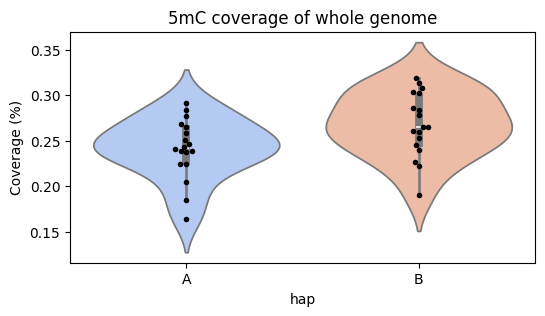

In [10]:
#plot 5mC coverage as violin plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
sns.violinplot(x='hap', y='Cov', data=bed_5mC_count, palette='coolwarm')
#add dot plot
sns.swarmplot(x='hap', y='Cov', data=bed_5mC_count, color='k', size=4)
plt.title('5mC coverage of whole genome')
plt.ylabel('Coverage (%)')
plt.show()


In [ ]:
bed_5mC_count =pd.merge(bed_5mC_count, telomere_df, left_on='chr', right_on='id', how='left')

,chr,size,count,Cov,hap,type
0,Chr01A,85591751,229230,0.267818,A,5mCpG
19,Chr01B,81879591,247551,0.302335,B,5mCpG
1,Chr02A,84617575,211671,0.250150,A,5mCpG
20,Chr02B,83031777,215669,0.259743,B,5mCpG
2,Chr03A,76987749,184976,0.240267,A,5mCpG
21,Chr03B,84687478,240530,0.284021,B,5mCpG
3,Chr04A,70778902,174353,0.246335,A,5mCpG
22,Chr04B,71071614,197329,0.277648,B,5mCpG
4,Chr05A,69948377,180550,0.258119,A,5mCpG
23,Chr05B,70239414,213208,0.303545,B,5mCpG


In [7]:
#Check whether methylation covering TE regions
#Read TE regions
TE = pd.read_table('../TE/Au3_TE.bed', header=None, comment='#')
TE.columns = ['chr', 'start', 'end', 'Div', 'strand', 'phase', 'id']


In [8]:
TE_bed = TE[['chr', 'start', 'end']]
#sort 
TE_bed = TE_bed.sort_values(by=['chr', 'start'])
TE_bed.columns = ['chrom', 'start', 'end']
#Convert to bed file
TE_bed = BedTool.from_dataframe(TE_bed)
#Merge the TE bed
TE_bed = TE_bed.merge()
#intersect the bed files
bed_5mc_short = bed_5mC[['chr', 'start', 'end']]
bed_5mc_short = BedTool.from_dataframe(bed_5mc_short)
#TE_5mC = TE_bed.intersect(bed_5mc_short, wa=True, wb=True).to_dataframe()
TE_5mC = TE_bed.coverage(bed_5mc_short).to_dataframe()

TE_5mC

***** WARNING: File /tmp/pybedtools.06treohy.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

***** WARNING: File /tmp/pybedtools.06treohy.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512



,chrom,start,end,name,score,strand,thickStart
0,Chr01A,2,10118,0,0,10116,0.000000
1,Chr01A,11363,11663,1,1,300,0.003333
2,Chr01A,11836,12515,0,0,679,0.000000
3,Chr01A,12605,13954,2,2,1349,0.001483
4,Chr01A,14542,17922,4,4,3380,0.001183
...,...,...,...,...,...,...,...
474671,Chr18B,26461749,26464514,12,12,2765,0.004340
474672,Chr18B,26464515,26465053,1,1,538,0.001859
474673,Chr18B,26465068,26468954,25,25,3886,0.006433
474674,Chr18B,26468955,26472443,28,28,3488,0.008027


In [9]:
TE_5mC.groupby(['chrom']).sum('name').reset_index()

,chrom,start,end,name,score,strand,thickStart
0,Chr01A,767853151831,767930610087,223128,223128,77458256,49.218616
1,Chr01B,678482880551,678556976168,241295,241295,74095617,48.263893
2,Chr02A,764252647808,764328518322,204729,204729,75870514,43.029690
3,Chr02B,781648537032,781722873926,207270,207270,74336894,48.655957
4,Chr03A,636638567002,636707070002,178574,178574,68503000,43.414622
5,Chr03B,742750911704,742826887681,232879,232879,75975977,55.781107
6,Chr04A,582810002432,582873123891,168470,168470,63121459,36.833831
7,Chr04B,576031417986,576094885526,191253,191253,63467540,43.018889
8,Chr05A,520256388391,520319067245,174794,174794,62678854,32.489080
9,Chr05B,534736769264,534799450244,206338,206338,62680980,35.164464


In [10]:
TE_5mC_intersect = TE_5mC.groupby(['chrom']).sum('name').reset_index()
#Convert to dataframe
TE_5mC_intersect = TE_5mC_intersect[['chrom', 'name']]
TE_5mC_intersect.columns = ['chr', '5mC in TE']
TE_5mC_intersect = pd.merge(bed_5mC_count, TE_5mC_intersect, on='chr', how='left')
TE_5mC_intersect['5mC in TE.cov'] = TE_5mC_intersect['5mC in TE']*100/TE_5mC_intersect['count']
TE_5mC_intersect

,chr,size,count,Cov,hap,type,5mC in TE,5mC in TE.cov
0,Chr01A,85591751,229230,0.267818,A,5mCpG,223128,97.338045
1,Chr01B,81879591,247551,0.302335,B,5mCpG,241295,97.472844
2,Chr02A,84617575,211671,0.250150,A,5mCpG,204729,96.720382
3,Chr02B,83031777,215669,0.259743,B,5mCpG,207270,96.105606
4,Chr03A,76987749,184976,0.240267,A,5mCpG,178574,96.539010
5,Chr03B,84687478,240530,0.284021,B,5mCpG,232879,96.819108
6,Chr04A,70778902,174353,0.246335,A,5mCpG,168470,96.625811
7,Chr04B,71071614,197329,0.277648,B,5mCpG,191253,96.920878
8,Chr05A,69948377,180550,0.258119,A,5mCpG,174794,96.811963
9,Chr05B,70239414,213208,0.303545,B,5mCpG,206338,96.777794


In [14]:
hapA_TE_5mC = TE_5mC_intersect[(TE_5mC_intersect['hap'] == 'A') & (TE_5mC_intersect['chr'] != 'Chr14A')]
hapB_TE_5mC = TE_5mC_intersect[(TE_5mC_intersect['hap'] == 'B') & (TE_5mC_intersect['chr'] != 'Chr14B')]
stats.ttest_ind(hapA_TE_5mC['5mC in TE.cov'], hapB_TE_5mC['5mC in TE.cov'], alternative='less')

TtestResult(statistic=-0.501573053127541, pvalue=0.3097006677701556, df=32.0)

In [186]:
TE_5mC_intersect['5mC in TE.cov'].describe()

count    36.000000
mean     96.327561
std       0.852314
min      94.005401
25%      95.940628
50%      96.672209
75%      96.856737
max      97.472844
Name: 5mC in TE.cov, dtype: float64

In [189]:
TE_5mC_intersect['5mC in TE'].sum()/TE_5mC_intersect['count'].sum()

0.9655303991271221

In [13]:
print(TE_5mC_intersect['5mC in TE.cov'].min())
print(TE_5mC_intersect['5mC in TE.cov'].max())

94.00540133705229
97.4728439796244


/tmp/ipykernel_31279/2114766795.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='hap', x='5mC in TE.cov', data=TE_5mC_intersect, palette='coolwarm')


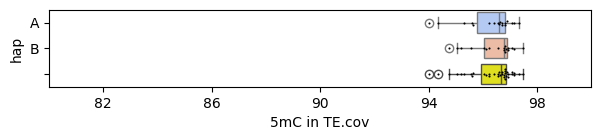

In [51]:
#Plot the coverage of 5mC in TE regions
plt.figure(figsize=(7, 1))
from seaborn import violinplot
import seaborn as sns
sns.boxplot(y='hap', x='5mC in TE.cov', data=TE_5mC_intersect, palette='coolwarm')
sns.boxplot(x='5mC in TE.cov', data=TE_5mC_intersect, color='yellow')
#add dot plot
sns.swarmplot(y='hap', x='5mC in TE.cov', data=TE_5mC_intersect, color='k', size=1.5)
sns.swarmplot(x='5mC in TE.cov', data=TE_5mC_intersect, color='k', size=1.5)
#plt.xlabel('Percentage of 5mCpG overlapping TEs (%)')
plt.xlim(80,100)
plt.xticks(np.arange(82, 102, 4))
#plt.savefig("/mnt/c/Users/lzy55/Downloads/boxplot_5mCpG_TE.svg", format="svg", bbox_inches="tight")
plt.show()


In [55]:
#tmp_A = TE_5mC_intersect[TE_5mC_intersect['chr'].str.contains('A') ]
tmp_A = TE_5mC_intersect[(TE_5mC_intersect['hap'] == 'A') & (TE_5mC_intersect['chr'] != 'Chr14A')]
#tmp_B = TE_5mC_intersect[TE_5mC_intersect['chr'].str.contains('B') ]
tmp_B = TE_5mC_intersect[(TE_5mC_intersect['hap'] == 'B') & (TE_5mC_intersect['chr'] != 'Chr14B')]
#tmp_B = TE_5mC_intersect[TE_5mC_intersect['chr'].str.contains('B') ]
stats.ttest_ind(tmp_B['5mC in TE.cov'], tmp_A['5mC in TE.cov'],alternative='greater')

TtestResult(statistic=0.501573053127541, pvalue=0.3097006677701556, df=32.0)

In [23]:
def calculate_dinucleotide_frequency(seqrecords):
    seq_id = seqrecords.id
    seq = str(seqrecords.seq)
    #Turn to upper case
    seq = seq.upper()
    dinucleotide_freq = {seq_id: {}}
    dinucleotide_types = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    total_dinucleotides = 0
    for i in range(len(seq) - 1):
        if seq[i:i+2] in dinucleotide_types:
            total_dinucleotides += 1
            # Count the number of each dinucleotide
            dinucleotide_freq[seq_id][seq[i:i+2]] = dinucleotide_freq[seq_id].get(seq[i:i+2], 0) + 1

    return dinucleotide_freq

In [95]:
def get_CpG_position(seqrecords):
    seq_id = seqrecords.id
    seq = str(seqrecords.seq)
    #Turn to upper case
    seq = seq.upper()
    dinucleotide_df = pd.DataFrame()
    total_dinucleotides = 0
    for i in range(len(seq) - 1):
        if seq[i:i+2] == 'CG':
            # Count the number of each dinucleotide
            #Save the position of the dinucleotide
            tmp_df = pd.DataFrame({'chr': [seq_id], 'pos': [i]})
            dinucleotide_df = pd.concat([dinucleotide_df, tmp_df])

    return dinucleotide_df

In [102]:
def find_CpG_in_chromosome(chromosome_data):
    """Find all CpG sites in a single chromosome"""
    chr_id = chromosome_data.id
    sequence = chromosome_data.seq
    # Convert sequence to string and uppercase
    sequence = str(sequence).upper()
    
    # Find all occurrences of CG using regex
    matches = re.finditer(r'CG', sequence)
    
    # Create list of positions
    positions = [(chr_id, match.start(), match.start() + 2) for match in matches]
    #save the positions to a dataframe
    positions_df = pd.DataFrame(positions, columns=['chr', 'start', 'end'])
    return positions_df

In [100]:
#get chr1A sequence
CHR01A = [x for x in Au3_genome if 'Chr01A' in x.id][0]
CHR01B = [x for x in Au3_genome if 'Chr01B' in x.id][0]
CHR05A = [x for x in Au3_genome if 'Chr05A' in x.id][0]
CHR05B = [x for x in Au3_genome if 'Chr05B' in x.id][0]

In [103]:
CHR01A_CpG = find_CpG_in_chromosome(CHR01A)
CHR01B_CpG = find_CpG_in_chromosome(CHR01B)
CHR05A_CpG = find_CpG_in_chromosome(CHR05A)
CHR05B_CpG = find_CpG_in_chromosome(CHR05B)

In [108]:
#Save the CpG sites to a bed file
CHR01A_CpG.to_csv('CHR01A_CpG.bed', sep='\t', index=False, header=False)
CHR01B_CpG.to_csv('CHR01B_CpG.bed', sep='\t', index=False, header=False)
CHR05A_CpG.to_csv('CHR05A_CpG.bed', sep='\t', index=False, header=False)
CHR05B_CpG.to_csv('CHR05B_CpG.bed', sep='\t', index=False, header=False)

In [18]:
#Verify whether the 5mC sites are CpG sites
def verify_CpG_sites(bed_5mC, genome):
    #test if the 5mC sites are CpG sites
    for i in range(len(bed_5mC)):
        chr = bed_5mC['chr'][i]
        start = bed_5mC['start'][i]
        end = bed_5mC['end'][i]
        for chr_seq in genome:
            if chr_seq.id == chr:
                seq = str(chr_seq.seq)
                seq = seq.upper()
                if seq[start:start+2] == 'CG':
                    bed_5mC.loc[i, 'Type'] = 'CpG'
                else:
                    bed_5mC.loc[i, 'Type'] = 'Non-CpG'
    return bed_5mC

In [19]:
Au3_genome_hapA = list(SeqIO.parse('../Au3_CHR_hapA_v3.fasta', 'fasta'))
Au3_genome_hapB = list(SeqIO.parse('../Au3_CHR_hapB_v3.fasta', 'fasta'))
Au3_genome = Au3_genome_hapA + Au3_genome_hapB



In [20]:
Au3_genome_name = [seq.id for seq in Au3_genome]
Au3_genome_name = pd.DataFrame(Au3_genome_name, columns=['old'])
#Make new column, if HapA, then A, if HapB, then B
Au3_genome_name['old'] = Au3_genome_name['old'].str.replace('APSI_AU3_HapA_CHR14_ab', 'APSI_AU3_HapB_CHR14')
#If contains hapA, add A in the end, if contains hapB, add B in the end
Au3_genome_name['new'] = Au3_genome_name['old'].apply(lambda x: x + 'A' if 'HapA' in x else x + 'B')
Au3_genome_name['new'] = Au3_genome_name['new'].str.replace('APSI_AU3_HapA_CHR', 'Chr')
Au3_genome_name['new'] = Au3_genome_name['new'].str.replace('APSI_AU3_HapB_CHR', 'Chr')

In [21]:
#Change the sequence id
for i in range(len(Au3_genome)):
    new_id = Au3_genome_name['new'][i]
    Au3_genome[i].id = new_id

In [24]:
dinucleotide_freq_dict = {}

def update_dict(result):
    dinucleotide_freq_dict.update(result)

pool = mp.Pool(mp.cpu_count())

for result in pool.map(calculate_dinucleotide_frequency, Au3_genome):
    update_dict(result)

pool.close()
pool.join()


In [25]:
#Convert the dictionary to a dataframe and get CpG frequency
dinucleotide_freq_df = pd.DataFrame(dinucleotide_freq_dict).T
dinucleotide_freq_df = dinucleotide_freq_df[['CG']]

/tmp/ipykernel_31279/654173047.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hap', y='Cov', data=bed_5mC_merge, palette='coolwarm', legend=True)


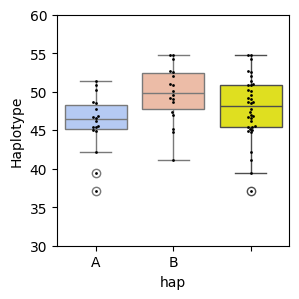

In [26]:
#merge the CpG frequency to the bed_5mC
bed_5mC_merge = pd.merge(bed_5mC_count, dinucleotide_freq_df, left_on='chr', right_index=True, how='left')
bed_5mC_merge['Cov'] = bed_5mC_merge['count']*100/bed_5mC_merge['CG']
#Plot the CpG frequency by haplotype with violin plot
plt.figure(figsize=(3, 3))
sns.boxplot(x='hap', y='Cov', data=bed_5mC_merge, palette='coolwarm', legend=True)

sns.boxplot(y='Cov', data=bed_5mC_merge, color='yellow')
#add dot plot
sns.swarmplot(x='hap', y='Cov', data=bed_5mC_merge, color='k', size=2)
sns.swarmplot(y='Cov', data=bed_5mC_merge, color='k', size=2)
plt.ylim(30, 60)
#plt.ylabel('Proportion of methylated CpG (%)')
plt.ylabel('Haplotype')

#plt.savefig("/mnt/c/Users/lzy55/Downloads/WG_5mCpG.svg", format="svg", bbox_inches="tight")
plt.show()

In [75]:
bed_5mC_merge

,chr,size,count,Cov,hap,type,CG
0,Chr01A,85591751,229230,48.667033,A,5mCpG,471017
19,Chr01B,81879591,247551,52.654853,B,5mCpG,470139
1,Chr02A,84617575,211671,46.811536,A,5mCpG,452177
20,Chr02B,83031777,215669,49.095015,B,5mCpG,439289
2,Chr03A,76987749,184976,45.446080,A,5mCpG,407023
21,Chr03B,84687478,240530,50.887511,B,5mCpG,472670
3,Chr04A,70778902,174353,46.719759,A,5mCpG,373189
22,Chr04B,71071614,197329,51.027907,B,5mCpG,386708
4,Chr05A,69948377,180550,47.708260,A,5mCpG,378446
23,Chr05B,70239414,213208,52.586819,B,5mCpG,405440


In [56]:
tmp_A = bed_5mC_merge[bed_5mC_merge['chr'].str.contains('A') & (bed_5mC_merge['chr'] != 'Chr14A')]
tmp_B = bed_5mC_merge[bed_5mC_merge['chr'].str.contains('B') & (bed_5mC_merge['chr'] != 'Chr14B')]
stats.ttest_ind(tmp_B['Cov'], tmp_A['Cov'],alternative='greater')

TtestResult(statistic=3.0914869857600014, pvalue=0.0020533809082572134, df=32.0)

In [29]:
tmp_A = bed_5mC_merge[bed_5mC_merge['chr'].str.contains('A') ]
tmp_B = bed_5mC_merge[bed_5mC_merge['chr'].str.contains('B') ]
stats.ttest_ind(tmp_B['Cov'], tmp_A['Cov'],alternative='greater')

TtestResult(statistic=3.002715467104881, pvalue=0.0024950781179283858, df=34.0)

In [59]:
#Pairwise t-test
stats.ttest_rel(tmp_B['Cov'], tmp_A['Cov'],alternative='greater')

TtestResult(statistic=10.097709668790284, pvalue=1.1994323669845101e-08, df=16)

In [67]:
Au3_genome_df = pd.DataFrame()
for seq in Au3_genome:
    seq_id = seq.id
    seq = str(seq.seq)
    seq = seq.upper()
    seq_df = pd.DataFrame({'chrom': [seq_id], 'size': len(seq)}, index=[0])
    Au3_genome_df = pd.concat([Au3_genome_df, seq_df])

In [69]:
# Calculate the length of each interval
TE_bed_df = TE_bed.to_dataframe()
TE_bed_df['length'] = TE_bed_df['end'] - TE_bed_df['start']

# Sum the lengths grouped by chromosome
TE_bed_length_sum = TE_bed_df.groupby(['chrom'])['length'].sum().reset_index()

In [70]:
#left join
TE_bed_length_sum = pd.merge(Au3_genome_df, TE_bed_length_sum, left_on='chrom', right_on='chrom', how='left')

In [72]:
TE_bed_length_sum['TE_cov'] = TE_bed_length_sum['length']*100/TE_bed_length_sum['size']

In [74]:
TE_hapA_tmp = TE_bed_length_sum[TE_bed_length_sum['chrom'].str.contains('A') & (TE_bed_length_sum['chrom'] != 'Chr14A')]
TE_hapB_tmp = TE_bed_length_sum[TE_bed_length_sum['chrom'].str.contains('B') & (TE_bed_length_sum['chrom'] != 'Chr14B')]
stats.ttest_ind(TE_hapB_tmp['TE_cov'], TE_hapA_tmp['TE_cov'],alternative='two-sided')

TtestResult(statistic=0.028754303327753986, pvalue=0.9772391317713319, df=32.0)

In [33]:
print(tmp_A['Cov'].describe(), tmp_B['Cov'].describe())

count    17.000000
mean     45.912894
std       3.725955
min      37.136844
25%      45.011924
50%      46.234204
75%      47.708260
max      51.382686
Name: Cov, dtype: float64 count    17.000000
mean     49.872823
std       3.742973
min      41.174498
25%      48.721602
50%      50.116189
75%      52.586819
max      54.787131
Name: Cov, dtype: float64


In [181]:
stats.wilcoxon(tmp_B['Cov'], tmp_A['Cov'],alternative='greater')


WilcoxonResult(statistic=170.0, pvalue=7.62939453125e-06)

In [2]:
gene = pd.read_table('../..//data/Au3_deduplicate/Au3_deduplicate.gff3', header=None, sep = '\t')
gene = gene[gene[2] == 'CDS']
gene.columns = ['Chr', 'source', 'type','start', 'end','phase1','strand','phase2','id']
gene = gene[['Chr','start','end','strand','id']]
gene['gene_id'] = gene['id'].str.split(';').str[0].str.split('.').str[0].str.split('=').str[1]
gene['Chr'] = gene['Chr'].str.replace('AU3_HapA_CHR14ab', 'AU3_HapB_CHR14')
#If contains hapA, add A in the end, if contains hapB, add B in the end
gene['Chr'] = gene['Chr'].apply(lambda x: x + 'A' if 'HapA' in x else x + 'B')
gene['Chr'] = gene['Chr'].str.replace('AU3_HapA_CHR', 'Chr')
gene['Chr']  = gene['Chr'].str.replace('AU3_HapB_CHR', 'Chr')

In [3]:
cds_bed = gene[['Chr','start','end']]
cds_bed = cds_bed.sort_values(by=['Chr','start'])

In [6]:
cds_bed.to_csv('../../data/Au3_CDS.bed', sep='\t', index=False, header=False)

In [38]:
cds_bed = BedTool.from_dataframe(cds_bed).merge()
cds_5mC = cds_bed.coverage(bed_5mc_short).to_dataframe()

***** WARNING: File /tmp/pybedtools.06treohy.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

***** WARNING: File /tmp/pybedtools.06treohy.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512



In [40]:
cds_5mC_intersect = cds_5mC.groupby(['chrom']).sum('name').reset_index()
#Convert to dataframe
cds_5mC_intersect = cds_5mC_intersect[['chrom', 'name']]
cds_5mC_intersect.columns = ['chr', '5mC in cds']
cds_5mC_intersect = pd.merge(bed_5mC_count, cds_5mC_intersect, on='chr', how='left')
cds_5mC_intersect['5mC in cds.cov'] = cds_5mC_intersect['5mC in cds']*100/cds_5mC_intersect['count']

In [41]:
cds_5mC_intersect['5mC in cds'].sum()/cds_5mC_intersect['count'].sum()

0.018408962936253777

/tmp/ipykernel_31279/2204415468.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='hap', x='5mC in cds.cov', data=cds_5mC_intersect, palette='coolwarm')


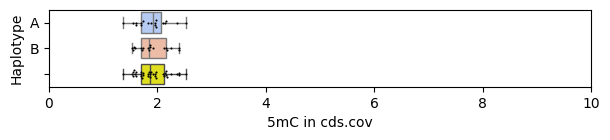

In [42]:
#Plot the CpG frequency by haplotype with violin plot
plt.figure(figsize=(7, 1))
sns.boxplot(y='hap', x='5mC in cds.cov', data=cds_5mC_intersect, palette='coolwarm')
#add dot plot
sns.swarmplot(y='hap', x='5mC in cds.cov', data=cds_5mC_intersect, color='k', size=1.5)
sns.boxplot( x='5mC in cds.cov', data=cds_5mC_intersect, color='yellow')
sns.swarmplot(x='5mC in cds.cov', data=cds_5mC_intersect, color='k', size=1.5)
plt.xlim(0, 10)
#plt.ylabel('Proportion of methylated CpG (%)')
plt.ylabel('Haplotype')
#plt.savefig("/mnt/c/Users/lzy55/Downloads/CDS_5mCpG.svg", format="svg", bbox_inches="tight")
plt.show()

In [46]:
tmp_A = cds_5mC_intersect[cds_5mC_intersect['chr'].str.contains('A') ]
tmp_B = cds_5mC_intersect[cds_5mC_intersect['chr'].str.contains('B') ]
stats.ttest_ind(tmp_B['5mC in cds.cov'], tmp_A['5mC in cds.cov'],alternative='two-sided')

TtestResult(statistic=0.03543809887482299, pvalue=0.9719376505414553, df=34.0)

In [50]:
tmp_A = cds_5mC_intersect[(cds_5mC_intersect['chr'].str.contains('A') ) & (cds_5mC_intersect['chr'] != 'Chr14A')]
tmp_B = cds_5mC_intersect[(cds_5mC_intersect['chr'].str.contains('B'))& (cds_5mC_intersect['chr'] != 'Chr14B')]
stats.ttest_ind(tmp_B['5mC in cds.cov'], tmp_A['5mC in cds.cov'],alternative='two-sided')

TtestResult(statistic=-0.3822289846263523, pvalue=0.7048183681648335, df=32.0)

In [156]:
#Compare 5UTR and 3UTR coverage of 5mCpG
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
p_value = mannwhitneyu(utr3_mCpG_intersect['5mC in utr3.cov'], utr5_mCpG_intersect['5mC in utr5.cov'], alternative='greater')
reject, pval_corrected, _, _ = multipletests(p_value, method='fdr_bh')
pval_corrected[1]
p_value = mannwhitneyu(utr3_mCpG_intersect['5mC in utr3.cov'], cds_5mC_intersect['5mC in cds.cov'], alternative='greater')
reject, pval_corrected, _, _ = multipletests(p_value, method='fdr_bh')
pval_corrected[1]

9.147475094415581e-12

In [8]:
gene_pos = gene.groupby(['Chr','gene_id', 'strand']).agg({'start': 'min', 'end': 'max'}).reset_index()

In [7]:
def calculate_5utr(row):
    if row['strand'] == '+':
        utr_start = max(0, row['start'] - 2000) 
        utr_end = row['start']
    elif row['strand'] == '-':
        utr_start = row['end']
        utr_end = row['end'] + 2000
    else:
        raise ValueError("Invalid strand value. Strand must be '+' or '-'.")
    
    return pd.Series([row['Chr'], utr_start, utr_end, row['gene_id'],  row['strand']])

def calculate_3utr(row):
    if row['strand'] == '+':
        utr_start = row['end']
        utr_end = row['end'] + 2000
    elif row['strand'] == '-':
        utr_start = max(0, row['start'] - 2000) 
        utr_end = row['start']
    else:
        raise ValueError("Invalid strand value. Strand must be '+' or '-'.")
    
    return pd.Series([row['Chr'], utr_start, utr_end, row['gene_id'],  row['strand']])
    

In [9]:
utr5_bed = gene_pos.apply(calculate_5utr, axis=1)
utr3_bed = gene_pos.apply(calculate_3utr, axis=1)

In [10]:
utr5_bed.sort_values([0,1]).to_csv('../../data/Au3_UTR5.bed', sep='\t', index=False, header=False)
utr3_bed.sort_values([0,1]).to_csv('../../data/Au3_UTR3.bed', sep='\t', index=False, header=False)

***** WARNING: File /tmp/pybedtools.p52fav89.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

***** WARNING: File /tmp/pybedtools.p52fav89.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

/tmp/ipykernel_96803/4135312166.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='hap', x='5mC in utr5.cov', data=utr5_mCpG_intersect, palette='coolwarm')


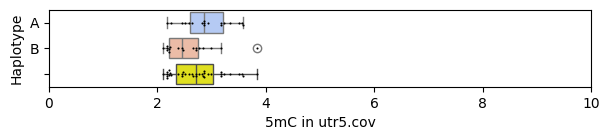

In [145]:
utr5_bed_short = utr5_bed.sort_values([0,1])
utr5_bed_short = BedTool.from_dataframe(utr5_bed_short[[0,1,2]]).merge()
utr5_mCpG = utr5_bed_short.coverage(bed_5mc_short).to_dataframe()
utr5_mCpG_intersect = utr5_mCpG.groupby(['chrom']).sum('name').reset_index()
#Convert to dataframe
utr5_mCpG_intersect = utr5_mCpG_intersect[['chrom', 'name']]
utr5_mCpG_intersect.columns = ['chr', '5mC in utr5']
utr5_mCpG_intersect = pd.merge(bed_5mC_count, utr5_mCpG_intersect, on='chr', how='left')
utr5_mCpG_intersect['5mC in utr5.cov'] = utr5_mCpG_intersect['5mC in utr5']*100/cds_5mC_intersect['count']
plt.figure(figsize=(7, 1))
sns.boxplot(y='hap', x='5mC in utr5.cov', data=utr5_mCpG_intersect, palette='coolwarm')
#add dot plot
sns.swarmplot(y='hap', x='5mC in utr5.cov', data=utr5_mCpG_intersect, color='k', size=1.5)
sns.boxplot( x='5mC in utr5.cov', data=utr5_mCpG_intersect, color='yellow')
sns.swarmplot(x='5mC in utr5.cov', data=utr5_mCpG_intersect, color='k', size=1.5)
plt.xlim(0, 10)
#plt.ylabel('Proportion of methylated CpG (%)')
plt.ylabel('Haplotype')
plt.savefig("/mnt/c/Users/lzy55/Downloads/5utr_5mCpG.svg", format="svg", bbox_inches="tight")
plt.show()

In [192]:
print(utr5_mCpG_intersect['5mC in utr5'].sum()/utr5_mCpG_intersect['count'].sum())
print(utr3_mCpG_intersect['5mC in utr3'].sum()/utr3_mCpG_intersect['count'].sum())

0.026395593009251733
0.02762881989543541


In [194]:
stats.ttest_ind(utr5_mCpG_intersect['5mC in utr5.cov'], utr3_mCpG_intersect['5mC in utr3.cov'],alternative='less')

TtestResult(statistic=-0.8366720748672962, pvalue=0.20281207275633045, df=70.0)

In [196]:
utr5_mCpG_intersect['5mC in utr5.cov'].describe()

count    36.000000
mean      2.742709
std       0.466404
min       2.111484
25%       2.347233
50%       2.711492
75%       3.033010
max       3.843708
Name: 5mC in utr5.cov, dtype: float64

In [197]:
utr3_mCpG_intersect['5mC in utr3.cov'].describe()

count    36.000000
mean      2.830123
std       0.418846
min       2.059133
25%       2.513460
50%       2.802918
75%       3.115403
max       3.596003
Name: 5mC in utr3.cov, dtype: float64

In [204]:
import scipy
scipy.__version__

'1.12.0'

In [198]:
cds_5mC_intersect['5mC in cds.cov'].describe()

count    36.000000
mean      1.898131
std       0.285410
min       1.371919
25%       1.699533
50%       1.864478
75%       2.123560
max       2.532430
Name: 5mC in cds.cov, dtype: float64

In [201]:
stats.ttest_ind(cds_5mC_intersect['5mC in cds.cov'], utr3_mCpG_intersect['5mC in utr3.cov'],alternative='less')

TtestResult(statistic=-11.032886499223174, pvalue=2.862621497451574e-17, df=70.0)

In [202]:
stats.ttest_ind(cds_5mC_intersect['5mC in cds.cov'], utr5_mCpG_intersect['5mC in utr5.cov'],alternative='less')

TtestResult(statistic=-9.267487513049156, pvalue=4.281684542892853e-14, df=70.0)

***** WARNING: File /tmp/pybedtools.p52fav89.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

***** WARNING: File /tmp/pybedtools.p52fav89.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

/tmp/ipykernel_96803/3062280827.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='hap', x='5mC in utr3.cov', data=utr3_mCpG_intersect, palette='coolwarm')


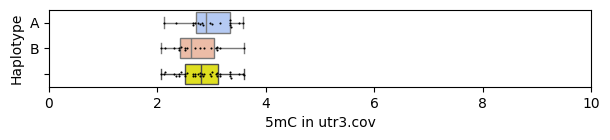

In [146]:
utr3_bed_short = utr3_bed.sort_values([0,1])
utr3_bed_short = BedTool.from_dataframe(utr3_bed_short[[0,1,2]]).merge()
utr3_mCpG = utr3_bed_short.coverage(bed_5mc_short).to_dataframe()
utr3_mCpG_intersect = utr3_mCpG.groupby(['chrom']).sum('name').reset_index()
#Convert to dataframe
utr3_mCpG_intersect = utr3_mCpG_intersect[['chrom', 'name']]
utr3_mCpG_intersect.columns = ['chr', '5mC in utr3']
utr3_mCpG_intersect = pd.merge(bed_5mC_count, utr3_mCpG_intersect, on='chr', how='left')
utr3_mCpG_intersect['5mC in utr3.cov'] = utr3_mCpG_intersect['5mC in utr3']*100/cds_5mC_intersect['count']
plt.figure(figsize=(7, 1))
sns.boxplot(y='hap', x='5mC in utr3.cov', data=utr3_mCpG_intersect, palette='coolwarm')
#add dot plot
sns.swarmplot(y='hap', x='5mC in utr3.cov', data=utr3_mCpG_intersect, color='k', size=1.5)
sns.boxplot( x='5mC in utr3.cov', data=utr3_mCpG_intersect, color='yellow')
sns.swarmplot(x='5mC in utr3.cov', data=utr3_mCpG_intersect, color='k', size=1.5)
plt.xlim(0, 10)
#plt.ylabel('Proportion of methylated CpG (%)')
plt.ylabel('Haplotype')
plt.savefig("/mnt/c/Users/lzy55/Downloads/3utr_5mCpG.svg", format="svg", bbox_inches="tight")
plt.show()

In [143]:
utr5_mCpG

,chrom,start,end,name,score,strand,thickStart
0,Chr01A,130870,132870,4,4,2000,0.002000
1,Chr01A,157775,159775,0,0,2000,0.000000
2,Chr01A,195429,197429,3,3,2000,0.001500
3,Chr01A,311912,315745,1,1,3833,0.000261
4,Chr01A,526247,529794,0,0,3547,0.000000
...,...,...,...,...,...,...,...
29823,Chr18B,26054617,26056617,28,28,2000,0.014000
29824,Chr18B,26305887,26307887,0,0,2000,0.000000
29825,Chr18B,26308460,26310460,0,0,2000,0.000000
29826,Chr18B,26382378,26384378,5,5,2000,0.002500


In [ ]:
stats.pearsonr(x, y, *, alternative='two-sided', method=None, axis=0)

/tmp/ipykernel_1462/1602697259.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hap', y='Cov', data=bed_4mC_count, palette='coolwarm')


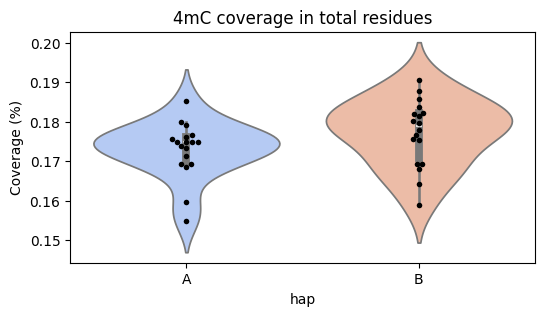

In [172]:
#plot 5mC coverage as violin plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
sns.violinplot(x='hap', y='Cov', data=bed_4mC_count, palette='coolwarm')
#add dot plot
sns.swarmplot(x='hap', y='Cov', data=bed_4mC_count, color='k', size=4)
plt.title('4mC coverage in total residues')
plt.ylabel('Coverage (%)')
plt.show()


In [176]:
#Add a column for C count in bed_4mC_count
for i in range(0, len(fna_rename)):
    C_count = fna_rename[i].seq.count('C')
    bed_4mC_count.loc[bed_4mC_count['chr'] == fna_rename[i].id, 'C_count'] = C_count

In [186]:
for i in range(0, len(fna_rename)):
    C_count = fna_rename[i].seq.count('C')
    bed_5mC_count.loc[bed_5mC_count['chr'] == fna_rename[i].id, 'C_count'] = C_count


In [178]:
bed_4mC_count['C_cov']= bed_4mC_count['count']*100/bed_4mC_count['C_count']


In [189]:
bed_5mC_count['C_cov']= bed_5mC_count['count']*100/bed_5mC_count['C_count']

/tmp/ipykernel_1462/2123845319.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hap', y='C_cov', data=bed_5mC_count, palette='coolwarm')


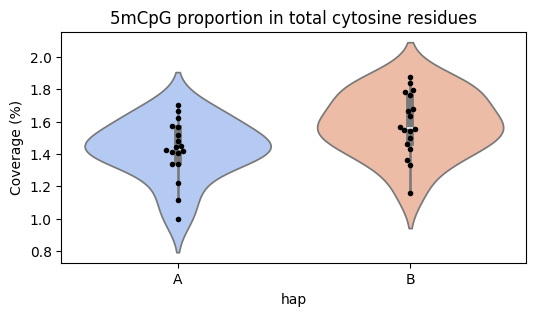

In [190]:
plt.figure(figsize=(6, 3))
sns.violinplot(x='hap', y='C_cov', data=bed_5mC_count, palette='coolwarm')
#add dot plot
sns.swarmplot(x='hap', y='C_cov', data=bed_5mC_count, color='k', size=4)
plt.title('5mCpG proportion in total cytosine residues')
plt.ylabel('Coverage (%)')
plt.show()

/tmp/ipykernel_1462/3796124269.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hap', y='C_cov', data=bed_4mC_count, palette='coolwarm')


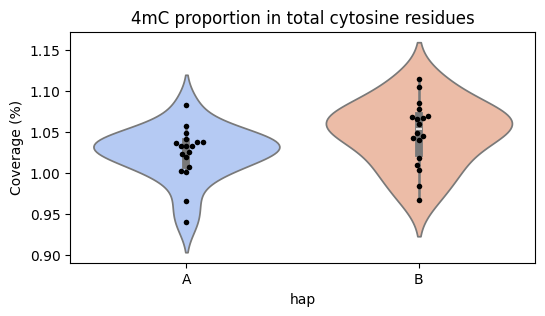

In [182]:
#Plot 4mC coverage in C residues
plt.figure(figsize=(6, 3))
sns.violinplot(x='hap', y='C_cov', data=bed_4mC_count, palette='coolwarm')
#add dot plot
sns.swarmplot(x='hap', y='C_cov', data=bed_4mC_count, color='k', size=4)
plt.title('4mC proportion in total cytosine residues')
plt.ylabel('Coverage (%)')
plt.show()

/tmp/ipykernel_1462/2772126211.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hap', y='A_cov', data=bed_6mA_count, palette='coolwarm')


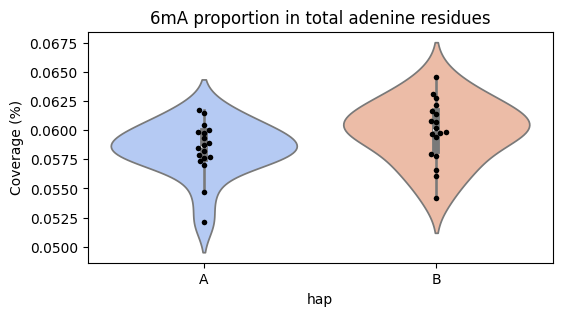

In [183]:
for i in range(0, len(fna_rename)):
    A_count = fna_rename[i].seq.count('A')
    bed_6mA_count.loc[bed_6mA_count['chr'] == fna_rename[i].id, 'A_count'] = A_count
bed_6mA_count['A_cov']= bed_6mA_count['count']*100/bed_6mA_count['A_count']
plt.figure(figsize=(6, 3))
sns.violinplot(x='hap', y='A_cov', data=bed_6mA_count, palette='coolwarm')
#add dot plot
sns.swarmplot(x='hap', y='A_cov', data=bed_6mA_count, color='k', size=4)
plt.title('6mA proportion in total adenine residues')
plt.ylabel('Coverage (%)')
plt.show()

/tmp/ipykernel_1462/433359152.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hap', y='Cov', data=bed_6mA_count, palette='coolwarm')


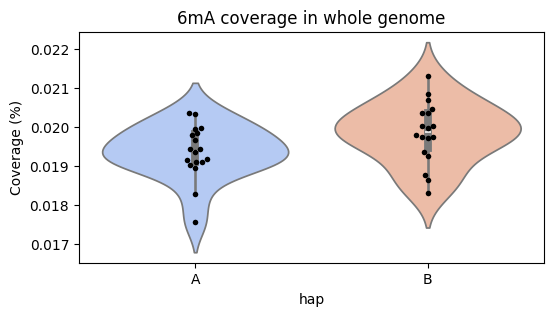

In [184]:
#plot 5mC coverage as violin plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
sns.violinplot(x='hap', y='Cov', data=bed_6mA_count, palette='coolwarm')
#add dot plot
sns.swarmplot(x='hap', y='Cov', data=bed_6mA_count, color='k', size=4)
plt.title('6mA coverage in whole genome')
plt.ylabel('Coverage (%)')
plt.show()


/tmp/ipykernel_1462/3816882187.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='type', y='Cov', data=Methy_count, palette='coolwarm')


Text(0, 0.5, 'Coverage (%)')

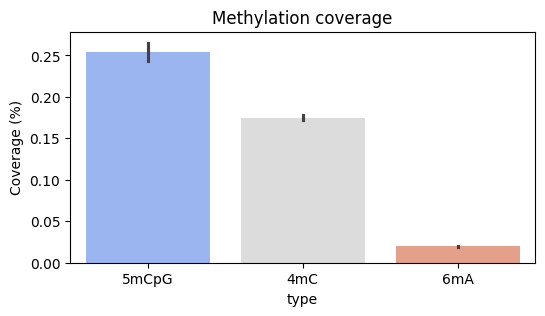

In [130]:
#Make a bar plot of the coverage of 5mC, 4mC and 6mA
plt.figure(figsize=(6, 3))
sns.barplot(x='type', y='Cov', data=Methy_count, palette='coolwarm')
plt.title('Methylation coverage')
plt.ylabel('Coverage (%)')

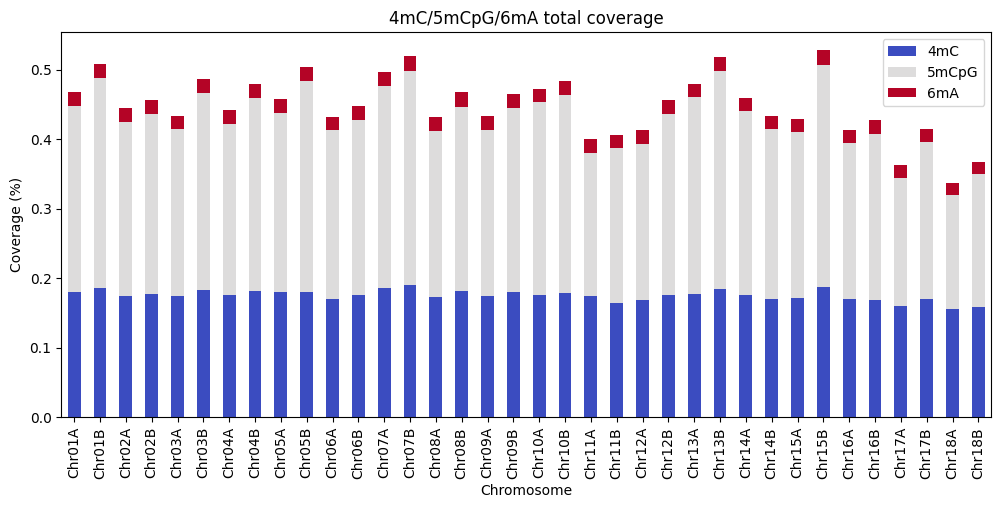

In [185]:
#Make bar plot of the coverage of 5mC, 4mC and 6mA for each chromosome, separated by haplotype, stacked by type
pivot_df = Methy_count.pivot_table(index='chr', columns='type', values='Cov', aggfunc='sum').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 5), colormap='coolwarm')
plt.title('4mC/5mCpG/6mA total coverage')
plt.ylabel('Coverage (%)')
plt.xlabel('Chromosome')
plt.legend(loc='upper right')
plt.show()

In [50]:
fna_hapA = list(SeqIO.parse('../Au3_CHR_hapA_v3.fasta', 'fasta'))
fna_hapB = list(SeqIO.parse('../Au3_CHR_hapB_v3.fasta', 'fasta'))



In [62]:
CpG_df = pd.DataFrame()
for i in range(0, len(fna_hapA)):
    seq = fna_hapA[i].seq
    CpG_count = seq.count('CG')
    CpG_cov = CpG_count*100/len(seq)
    tmp = pd.DataFrame({'chr': fna_hapA[i].id, 'CpG_count': CpG_count, 'CpG_cov': CpG_cov}, index=[0])
    CpG_df = pd.concat([CpG_df, tmp])
for i in range(0, len(fna_hapB)):
    seq = fna_hapB[i].seq
    CpG_count = seq.count('CG')
    CpG_cov = CpG_count*100/len(seq)
    tmp = pd.DataFrame({'chr': fna_hapB[i].id, 'CpG_count': CpG_count, 'CpG_cov': CpG_cov}, index=[0])
    CpG_df = pd.concat([CpG_df, tmp])

In [89]:
fna_rename = []
for i in range(0, len(fna_hapA)):
    seq = fna_hapA[i].seq
    if re.search(r'HapA', fna_hapA[i].id):
        hap = 'A'
    else:
        hap = 'B'
    chr = fna_hapA[i].id.split('_')[3]
    chr = chr.replace('CHR', 'Chr')
    header = chr+hap
    if fna_hapA[i].id == 'APSI_AU3_HapA_CHR14_ab':
        header = 'Chr14B'
    fna_rename.append(SeqIO.SeqRecord(seq, id=header, description=''))
for i in range(0, len(fna_hapB)):
    seq = fna_hapB[i].seq
    if re.search(r'HapA', fna_hapB[i].id):
        hap = 'A'
    else:
        hap = 'B'
    chr = fna_hapB[i].id.split('_')[3]
    chr = chr.replace('CHR', 'Chr')
    header = chr+hap
    fna_rename.append(SeqIO.SeqRecord(seq, id=header, description=''))
    

In [134]:
CG_content = pd.DataFrame()
for i in range(0, len(fna_rename)):
    seq = fna_rename[i].seq
    C_count = seq.count('C')
    G_count = seq.count('G')
    seq_len = len(seq)
    CG_cov = (C_count+G_count)*100/seq_len
    tmp = pd.DataFrame({'chr': fna_rename[i].id, 'C_count': C_count, 'G_count':G_count, 'CG_count': C_count+G_count, 'CG_cov': CG_cov}, index=[0])
    CG_content = pd.concat([CG_content, tmp])

In [142]:
#Merge CpG and CG content
CG_content_df = pd.merge(CG_content, CpG_df, on='chr', how='left')
CG_content_df['Percentage of methylated Cytosine residue of total cytosine'] = CG_content_df['CpG_count']*100/CG_content_df['C_count']

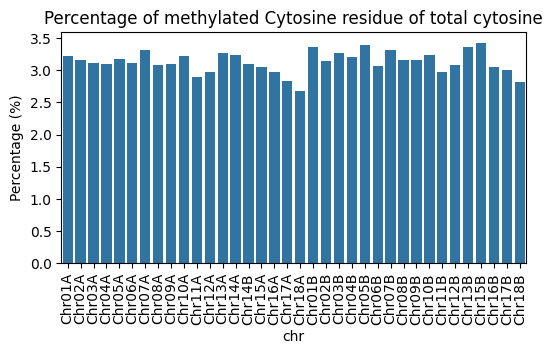

In [146]:
#plot Percentage of methylated Cytosine residue of total cytosine
plt.figure(figsize=(6, 3))
sns.barplot(x='chr', y='Percentage of methylated Cytosine residue of total cytosine', data=CG_content_df)
plt.title('Percentage of methylated Cytosine residue of total cytosine')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=90)
plt.show()

In [152]:
CG_content_df['chr_num'] = CG_content_df['chr'].str.extract('(\d+)').astype(int)
CG_content_df.sort_values(by=['chr_num'], ascending=True, inplace=True)
#Run pair t-test to compare the percentage of methylated Cytosine residue of total cytosine between haplotype A and B
from scipy.stats import ttest_ind
hapA = CG_content_df[CG_content_df['chr'].str.contains('A')]['Percentage of methylated Cytosine residue of total cytosine']
hapB = CG_content_df[CG_content_df['chr'].str.contains('B')]['Percentage of methylated Cytosine residue of total cytosine']
ttest_ind(hapA, hapB)


TtestResult(statistic=-1.6039463736202548, pvalue=0.11797627226738112, df=34.0)

In [149]:
max(CG_content_df['Percentage of methylated Cytosine residue of total cytosine'])

3.4222003279633157

In [65]:
#If chr contain HapA, then hap = A, else hap = B
CpG_df['chr'] = CpG_df['chr'].str.replace('APSI_AU3_HapA_CHR14_ab', 'APSI_AU3_HapB_CHR14')
CpG_df['chr'] = CpG_df['chr'].str.replace('CHR', 'Chr')
CpG_df['hap'] = np.where(CpG_df['chr'].str.contains('HapA'), 'A', 'B')
CpG_df['chr'] = CpG_df['chr'].str.split('_').str[3]  + CpG_df['hap']

In [132]:
bed_5mC_count_df2 = bed_5mC_count[['chr', 'count']]
bed_5mC_count_df2.columns = ['chr', '5mC_count']
#left join
CpG_df2 = pd.merge(CpG_df, bed_5mC_count_df2, on='chr', how='left')
CpG_df2['5mC_per_CpG'] = CpG_df2['5mC_count']*100/CpG_df2['CpG_count']
CpG_df2_5mCpG = CpG_df2[['chr', '5mC_per_CpG']]
CpG_df2_5mCpG['type'] = '5mCpG'
CpG_df2_5mCpG.columns = ['chr', 'Cov', 'type']
CpG_df2_no5mCpG = CpG_df2[['chr', '5mC_per_CpG']]
CpG_df2_no5mCpG['Cov'] = 100 - CpG_df2_no5mCpG['5mC_per_CpG']
CpG_df2_no5mCpG['type'] = 'No5mCpG'
CpG_merge = pd.concat([CpG_df2_5mCpG, CpG_df2_no5mCpG])
CpG_merge = CpG_merge.drop('5mC_per_CpG', axis=1)


/tmp/ipykernel_1462/4169835476.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CpG_df2_5mCpG['type'] = '5mCpG'
/tmp/ipykernel_1462/4169835476.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CpG_df2_no5mCpG['Cov'] = 100 - CpG_df2_no5mCpG['5mC_per_CpG']
/tmp/ipykernel_1462/4169835476.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [153]:
CpG_merge

,chr,Cov,type
0,Chr01A,48.667033,5mCpG
1,Chr02A,46.811536,5mCpG
2,Chr03A,45.446080,5mCpG
3,Chr04A,46.719759,5mCpG
4,Chr05A,47.708260,5mCpG
...,...,...,...
31,Chr13B,45.228345,No5mCpG
32,Chr15B,45.212869,No5mCpG
33,Chr16B,52.991009,No5mCpG
34,Chr17B,54.785457,No5mCpG


In [156]:
CpG_merge['chr_num'] = CpG_merge['chr'].str.extract('(\d+)').astype(int)
CpG_merge['hap']= CpG_merge['chr'].str[-1]
CpG_merge.sort_values(by=['chr_num'], ascending=True, inplace=True)
#Run pair t-test to compare the percentage of methylated Cytosine residue of total cytosine between haplotype A and B
hapA = CpG_merge[CpG_merge['chr'].str.contains('A')]
hapA_methy = hapA[hapA['type'] == '5mCpG']['Cov']
hapB = CpG_merge[CpG_merge['chr'].str.contains('B')]
hapB_methy = hapB[hapB['type'] == '5mCpG']['Cov']
ttest_ind(hapA_methy, hapB_methy)


TtestResult(statistic=-3.002715467104881, pvalue=0.0049901562358567715, df=34.0)

/tmp/ipykernel_1462/736805703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hap', y='Cov', data=CpG_merge_5mCpG, palette='coolwarm')


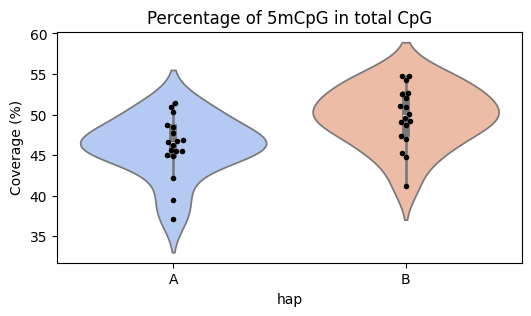

In [171]:
#Plot the percentage of 5mCpG and No5mCpG

plt.figure(figsize=(6, 3))
CpG_merge_no5mCpG = CpG_merge[CpG_merge['type'] == 'No5mCpG']
#sns.violinplot(x='hap', y='Cov', data=CpG_merge_no5mCpG, palette='coolwarm')
#add dot plot
#sns.swarmplot(x='hap', y='Cov', data=CpG_merge_no5mCpG, color='k', size=4)
CpG_merge_5mCpG = CpG_merge[CpG_merge['type'] == '5mCpG']
sns.violinplot(x='hap', y='Cov', data=CpG_merge_5mCpG, palette='coolwarm')
#add dot plot
sns.swarmplot(x='hap', y='Cov', data=CpG_merge_5mCpG, color='k', size=4)

plt.title('Percentage of 5mCpG in total CpG')
plt.ylabel('Coverage (%)')
plt.show()


In [164]:
len(hapA_methy)

18

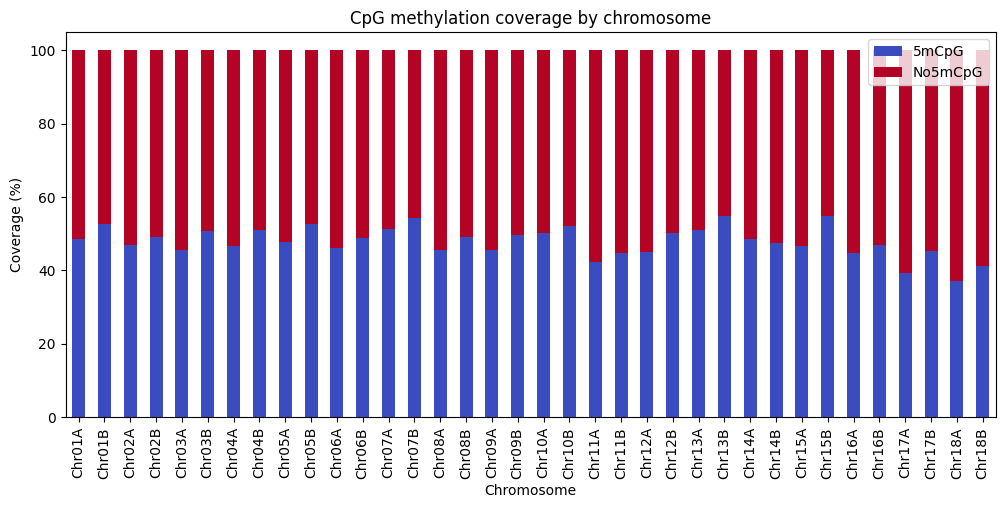

In [133]:
pivot_df = CpG_merge.pivot_table(index='chr', columns='type', values='Cov', aggfunc='sum').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 5), colormap='coolwarm')
plt.title('CpG methylation coverage by chromosome')
plt.ylabel('Coverage (%)')
plt.xlabel('Chromosome')
plt.legend(loc='upper right')
plt.show()

In [195]:
ApT_df = pd.read_table('Au3_6mApT_filtered.bed', header=None)
ApT_df0 = bed_6mA_count[['chr','count']]
ApT_df.columns = ['chr', 'start', 'end', 'strand','score']
ApT_count = ApT_df.groupby(['chr']).size().reset_index(name='count')
for i in range(0, len(fna_rename)):
    ApT_counter = fna_rename[i].seq.count('AT')
    ApT_count.loc[ApT_count['chr'] == fna_rename[i].id, 'ApT_count'] = ApT_counter
ApT_count['Cov']= ApT_count['count']*100/ApT_count['ApT_count']

In [203]:
ApT_df0 = bed_6mA_count[['chr','count']].reset_index(drop=True)
ApT_df0 = ApT_df0.rename(columns={'count': '6mA_count'})
ApT_count = ApT_count.rename(columns={'count': '6mApT_count'})
ApT_count = pd.merge(ApT_count, ApT_df0, on='chr', how='left')
ApT_count['6mApT_per_6mA'] = ApT_count['6mApT_count']*100/ApT_count['6mA_count']

/tmp/ipykernel_1462/613990886.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='hap', y='6mApT_per_6mA', data=ApT_count, palette='coolwarm')


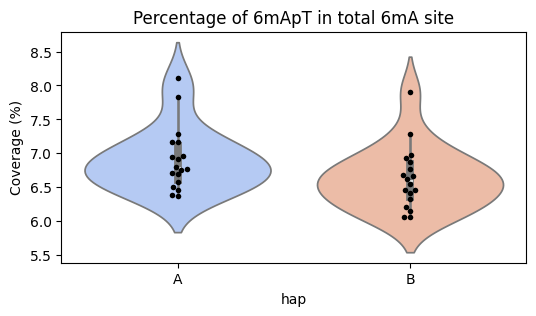

In [205]:
ApT_count['hap']= ApT_count['chr'].str[-1]
plt.figure(figsize=(6, 3))
sns.violinplot(x='hap', y='6mApT_per_6mA', data=ApT_count, palette='coolwarm')
#add dot plot
sns.swarmplot(x='hap', y='6mApT_per_6mA', data=ApT_count, color='k', size=4)

plt.title('Percentage of 6mApT in total 6mA site')
plt.ylabel('Coverage (%)')
plt.show()

In [208]:
ApT_count['6mApT_count']*100/ApT_count['ApT_count']

0     0.012470
1     0.012856
2     0.012016
3     0.012738
4     0.012346
5     0.012821
6     0.012538
7     0.012117
8     0.013813
9     0.012765
10    0.012379
11    0.013373
12    0.013834
13    0.012829
14    0.012839
15    0.013979
16    0.013207
17    0.012761
18    0.012102
19    0.012211
20    0.015063
21    0.013054
22    0.012904
23    0.013271
24    0.012569
25    0.011839
26    0.013177
27    0.011839
28    0.013139
29    0.012278
30    0.012392
31    0.012334
32    0.012726
33    0.012520
34    0.013540
35    0.013715
dtype: float64

In [ ]:
for i in range(0, len(fna_rename)):
    A_count = fna_rename[i].seq.count('A')
    bed_6mA_count.loc[bed_6mA_count['chr'] == fna_rename[i].id, 'A_count'] = A_count